In [1]:
import copy
import math

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA 

from sklearn.metrics import mean_squared_error, mean_squared_log_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def process_dataset(data): 
    
    df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date
    req_df = df.sort_values(by="InvoiceDate").groupby(["CustomerID", "InvoiceDate"]).last().reset_index()
    req_df = req_df[["CustomerID", "InvoiceDate"]]
    
    count_map = req_df.groupby("CustomerID")["InvoiceDate"].count().to_dict()
    req_df["count"] = req_df["CustomerID"].map(count_map)
    req_df = req_df[req_df["count"]>2]
    
    req_df["cum_count"] = req_df.groupby("CustomerID")["InvoiceDate"].cumcount()
    #req_df = req_df[req_df["cum_count"]<=10].reset_index(drop=True)
    
    return req_df

def sample_dataframe(data):
    
    dfs = []
    
    grouped = data.groupby("CustomerID")
    
    for _, group in grouped:
                
        if group["count"].max() > 40:
            split1 = group[group["cum_count"] <= 5].copy()
            split2 = group[(group["cum_count"] > 5) & (group["cum_count"] <= 10)].copy()
            split3 = group[(group["cum_count"] > 10) & (group["cum_count"] <= 15)].copy()
            split4 = group[(group["cum_count"] > 15) & (group["cum_count"] <= 20)].copy()
            split4 = group[(group["cum_count"] > 20) & (group["cum_count"] <= 25)].copy()
            split5 = group[(group["cum_count"] > 25) & (group["cum_count"] <= 30)].copy()
            split6 = group[(group["cum_count"] > 30) & (group["cum_count"] <= 35)].copy()
            split7 = group[group["cum_count"] > 35].copy()
            
            split1["CustomerID"] = split1["CustomerID"].astype(str) + "_1"
            split2["CustomerID"] = split2["CustomerID"].astype(str) + "_2"
            split3["CustomerID"] = split3["CustomerID"].astype(str) + "_3"
            split4["CustomerID"] = split4["CustomerID"].astype(str) + "_4"             
            split5["CustomerID"] = split5["CustomerID"].astype(str) + "_5"
            split6["CustomerID"] = split6["CustomerID"].astype(str) + "_6"
            split7["CustomerID"] = split7["CustomerID"].astype(str) + "_7"
            
            dfs.extend([split1, split2, split3, split4, split5, split6, split7])
        
        elif group["count"].max() > 20:
            split1 = group[group["cum_count"] <= 5].copy()
            split2 = group[(group["cum_count"] > 5) & (group["cum_count"] <= 10)].copy()
            split3 = group[(group["cum_count"] > 10) & (group["cum_count"] <= 15)].copy()
            split4 = group[group["cum_count"] > 15].copy()
            
            split1["CustomerID"] = split1["CustomerID"].astype(str) + "_1"
            split2["CustomerID"] = split2["CustomerID"].astype(str) + "_2"
            split3["CustomerID"] = split3["CustomerID"].astype(str) + "_3"
            split4["CustomerID"] = split4["CustomerID"].astype(str) + "_4"
            
            dfs.extend([split1, split2, split3])
        
        elif group["count"].max() > 10:
            split1 = group[group["cum_count"] <= 3].copy()
            split2 = group[(group["cum_count"] > 3) & (group["cum_count"] <= 7)].copy()
            split3 = group[group["cum_count"] > 7].copy()
            
            split1["CustomerID"] = split1["CustomerID"].astype(str) + "_1"
            split2["CustomerID"] = split2["CustomerID"].astype(str) + "_2"
            split3["CustomerID"] = split3["CustomerID"].astype(str) + "_3"
            
            dfs.extend([split1, split2, split3])
        
        elif group["count"].max() > 6:
            split1 = group[group["cum_count"] > 4].copy()
            split2 = group[group["cum_count"] <= 4].copy()
            
            split1["CustomerID"] = split1["CustomerID"].astype(str) + "_1"
            split2["CustomerID"] = split2["CustomerID"].astype(str) + "_2"
            
            dfs.extend([split1, split2])
        
        else:
            dfs.extend([group.copy()])
        
    df = pd.concat(dfs, axis=0, ignore_index=True)
    data = data[["CustomerID", "InvoiceDate"]]
    
    data["itt"] = data.groupby("CustomerID")["InvoiceDate"].diff().apply(lambda x: x.days)
    data.dropna(inplace=True)
    
    return data

def extract_features(df):
    
    df = copy.deepcopy(df)
    
    last_transaction_day_map = df.groupby("CustomerID")["itt"].last().to_dict()
    
    count_map = df.groupby("CustomerID")["InvoiceDate"].count().to_dict()
    df["count"] = df["CustomerID"].map(count_map)
    df = df[df["count"]>2]
    
    itt_df = df.groupby("CustomerID")["itt"].apply(list).to_frame().reset_index()
    itt_df["next_purchase_day"] = itt_df["CustomerID"].map(last_transaction_day_map)
    
    itt_df["itt"] = itt_df["itt"].apply(lambda x: x[:-1])
    
    itt_df["purchase_count"] = itt_df["itt"].apply(len)
    itt_df["min_itte"] = itt_df["itt"].apply(lambda x: min(x[-5:]))
    itt_df["max_itte"] = itt_df["itt"].apply(lambda x: min(x[-5:]))
    itt_df["mean_itte"] = itt_df["itt"].apply(lambda x: sum(x[-5:])/len(x[-5:]))
    
    itt_df["5th_percentile"] = itt_df["itt"].apply(lambda x: np.percentile(x[-5:], 5))
    itt_df["25th_percentile"] = itt_df["itt"].apply(lambda x: np.percentile(x[-5:], 25))
    itt_df["75th_percentile"] = itt_df["itt"].apply(lambda x: np.percentile(x[-5:], 75))
    itt_df["95th_percentile"] = itt_df["itt"].apply(lambda x: np.percentile(x[-5:], 95))

    itt_df["total_dur"] = itt_df["itt"].apply(sum)
    itt_df["last_interval"] = itt_df["itt"].apply(lambda x: x[-1])

    itt_df.drop("itt", axis=1, inplace=True)
    itt_df.drop("CustomerID", axis=1, inplace=True)
    
    itt_df = itt_df[itt_df["purchase_count"] != 1]
    
    return itt_df
    
def return_guess_score(pred, act):
    
    c= 0
    yt = act.values
    
    for i in range(len(pred)):
        if pred[i] >= (yt[i] * 0.85):
            c+=1
                
    return c/len(yt)

def determine_outlier_thresholds_std(dataframe, col_name):
    upper_boundary = dataframe[col_name].mean() + 3 * dataframe[col_name].std()
    lower_boundary = dataframe[col_name].mean() - 3 * dataframe[col_name].std()
    return lower_boundary, upper_boundary

def remove_outliers(data):
    
    print("before_removal\t: ", data.shape[0])
        
    avail_cols = data.columns.tolist()
    avail_cols.remove("next_purchase_day")
    
    lt_array = []
    ut_array = []
    
    for col in avail_cols:
        lt, ut = determine_outlier_thresholds_std(data, col)
        print("col_name :: {}\t| upper_threshold :: {}\t|| lower_threshold :: {}".format(col, ut, lt))
        lt_array.append(lt)
        ut_array.append(ut)

    for index, _ in enumerate(avail_cols):
        data = data[(data[col]>=lt_array[index]) & (data[col]<=ut_array[index])]
    
    print("before_removal\t: ", data.shape[0])
        
    return data

def calc_vif(X):
    """
    Calculate Variance Inflation Factor (VIF) for each variable in the DataFrame.

    Parameters:
    - X: pandas DataFrame with independent variables.

    Returns:
    - vif: DataFrame with variable names and their corresponding VIF values.
    """
    vif = pd.DataFrame({'variables': X.columns,
                        'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]})
    
    remove_cols = vif[vif["VIF"]>10]["variables"]
    return remove_cols

# Reading the data

In [3]:
df = pd.read_csv("/Users/arjun-14756/Desktop/test_files/OnlineRetail 2.csv", encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


# Processing, sampling and feature engineering

In [4]:
df = process_dataset(df)
print("before_sampling\n", df["CustomerID"].nunique())
df = sample_dataframe(df)
print("after_sampling\n", df["CustomerID"].nunique())

processed_df = extract_features(df)
processed_df.head()

before_sampling
 2133


/var/folders/j6/frt381rd1c11cs1fzwmd2zd04sv38d/T/ipykernel_60608/4144699806.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["itt"] = data.groupby("CustomerID")["InvoiceDate"].diff().apply(lambda x: x.days)
/Users/arjun-14756/anaconda3/lib/python3.10/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


after_sampling
 2133


,next_purchase_day,purchase_count,min_itte,max_itte,mean_itte,5th_percentile,25th_percentile,75th_percentile,95th_percentile,total_dur,last_interval
0,55.0,5,8.0,8.0,84.20,9.00,13.00,146.00,187.60,421.0,56.0
1,144.0,2,40.0,40.0,69.50,42.95,54.75,84.25,96.05,139.0,99.0
2,8.0,5,5.0,5.0,52.00,5.20,6.00,44.00,154.40,260.0,182.0
3,49.0,4,22.0,22.0,60.75,24.40,34.00,85.75,99.55,243.0,103.0
4,18.0,11,2.0,2.0,16.60,2.00,2.00,28.00,37.60,266.0,2.0


# Removing outliers

In [5]:
processed_df.describe()

,next_purchase_day,purchase_count,min_itte,max_itte,mean_itte,5th_percentile,25th_percentile,75th_percentile,95th_percentile,total_dur,last_interval
count,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000,1634.000000
mean,44.698898,6.997552,18.805998,18.805998,55.835761,21.598868,32.770349,71.928244,99.312454,278.727050,46.405141
std,46.616925,9.202491,26.476063,26.476063,43.088312,27.115021,32.952476,57.213471,75.342155,159.295887,48.559455
min,1.000000,2.000000,1.000000,1.000000,1.400000,1.000000,1.000000,1.000000,2.600000,7.000000,1.000000
25%,12.000000,3.000000,4.000000,4.000000,26.600000,5.612500,10.562500,32.312500,47.250000,160.000000,12.000000
50%,29.000000,4.000000,9.000000,9.000000,44.266667,11.600000,22.000000,57.000000,80.800000,252.000000,30.000000
75%,62.000000,8.000000,23.000000,23.000000,72.187500,26.800000,43.937500,92.500000,126.400000,343.000000,64.750000
max,338.000000,144.000000,214.000000,214.000000,302.500000,218.200000,239.000000,448.250000,564.850000,695.000000,321.000000


In [6]:
processed_df = remove_outliers(processed_df)
processed_df.head()

before_removal	:  1634
col_name :: purchase_count	| upper_threshold :: 34.60502626728045	|| lower_threshold :: -20.609922228112765
col_name :: min_itte	| upper_threshold :: 98.23418790371352	|| lower_threshold :: -60.62219279967436
col_name :: max_itte	| upper_threshold :: 98.23418790371352	|| lower_threshold :: -60.62219279967436
col_name :: mean_itte	| upper_threshold :: 185.100696689816	|| lower_threshold :: -73.42917486199065
col_name :: 5th_percentile	| upper_threshold :: 102.9439302761958	|| lower_threshold :: -59.74619465808073
col_name :: 25th_percentile	| upper_threshold :: 131.6277765415303	|| lower_threshold :: -66.0870788671117
col_name :: 75th_percentile	| upper_threshold :: 243.56865529227662	|| lower_threshold :: -99.7121681441738
col_name :: 95th_percentile	| upper_threshold :: 325.3389187520133	|| lower_threshold :: -126.71401055127933
col_name :: total_dur	| upper_threshold :: 756.6147109119815	|| lower_threshold :: -199.16061054478445
col_name :: last_interval	| uppe

,next_purchase_day,purchase_count,min_itte,max_itte,mean_itte,5th_percentile,25th_percentile,75th_percentile,95th_percentile,total_dur,last_interval
4,18.0,11,2.0,2.0,16.600000,2.0,2.0,28.00,37.60,266.0,2.0
5,38.0,2,34.0,34.0,111.000000,41.7,72.5,149.50,180.30,222.0,34.0
7,25.0,3,10.0,10.0,36.666667,11.2,16.0,50.00,72.40,110.0,10.0
8,2.0,4,28.0,28.0,52.500000,28.3,29.5,73.50,79.50,210.0,28.0
10,60.0,4,12.0,12.0,62.750000,13.5,19.5,79.75,148.75,251.0,22.0


<AxesSubplot:ylabel='Density'>

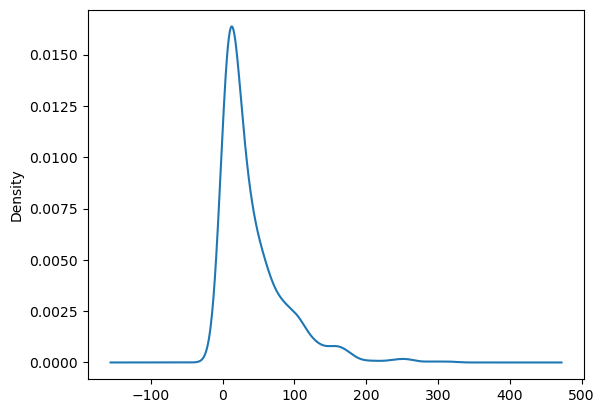

In [7]:
processed_df["next_purchase_day"].plot(kind="kde")

In [8]:
x = processed_df.drop("next_purchase_day", axis=1)
y = processed_df["next_purchase_day"]

x.head()

,purchase_count,min_itte,max_itte,mean_itte,5th_percentile,25th_percentile,75th_percentile,95th_percentile,total_dur,last_interval
4,11,2.0,2.0,16.600000,2.0,2.0,28.00,37.60,266.0,2.0
5,2,34.0,34.0,111.000000,41.7,72.5,149.50,180.30,222.0,34.0
7,3,10.0,10.0,36.666667,11.2,16.0,50.00,72.40,110.0,10.0
8,4,28.0,28.0,52.500000,28.3,29.5,73.50,79.50,210.0,28.0
10,4,12.0,12.0,62.750000,13.5,19.5,79.75,148.75,251.0,22.0


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

for col in ["purchase_count", "total_dur", "last_interval"]:
    
    model = KMeans(n_clusters=5)  
    model.fit(x_train[[col]])    
    x_train[col+"_cluster"] = model.predict(x_train[[col]])
    x_test[col+"_cluster"] = model.predict(x_test[[col]])

In [10]:
x_train["score"] = x_train["purchase_count_cluster"] + x_train["total_dur"] + x_train["last_interval_cluster"]
x_test["score"] = x_test["purchase_count_cluster"] + x_test["total_dur"] + x_test["last_interval_cluster"]

# Correlation analysis

<AxesSubplot:>

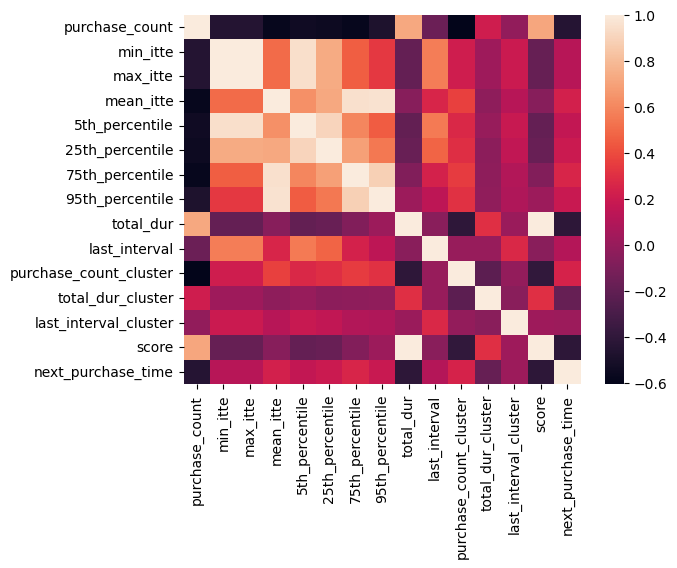

In [11]:
corr_check = copy.deepcopy(x_train)
corr_check["next_purchase_time"] = y_train
sns.heatmap(corr_check.corr(method="spearman"))

In [12]:
for col in x_train.columns:
    print("Corr_with", x_train[[col]].corrwith(y_train, method="spearman"))

Corr_with purchase_count   -0.447389
dtype: float64
Corr_with min_itte    0.116928
dtype: float64
Corr_with max_itte    0.116928
dtype: float64
Corr_with mean_itte    0.23181
dtype: float64
Corr_with 5th_percentile    0.164213
dtype: float64
Corr_with 25th_percentile    0.194574
dtype: float64
Corr_with 75th_percentile    0.25792
dtype: float64
Corr_with 95th_percentile    0.191061
dtype: float64
Corr_with total_dur   -0.414654
dtype: float64
Corr_with last_interval    0.106481
dtype: float64
Corr_with purchase_count_cluster    0.242972
dtype: float64
Corr_with total_dur_cluster   -0.182037
dtype: float64
Corr_with last_interval_cluster    0.016396
dtype: float64
Corr_with score   -0.414079
dtype: float64


# Next purchase date distribution - Non Gaussian

[Text(0.5, 1.0, 'Next Purchase Time in Training Data'), Text(0.5, 0, 'days')]

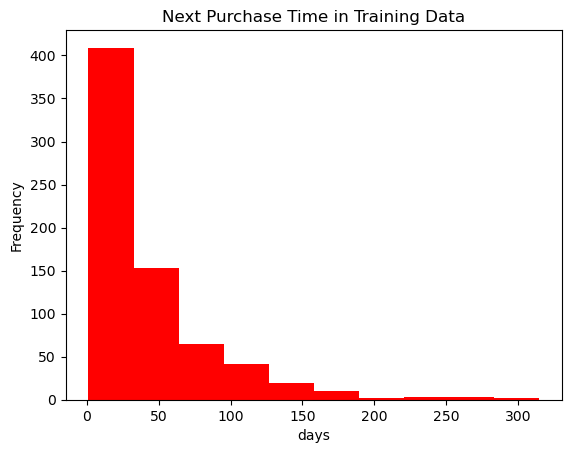

In [13]:
y_train.plot(kind="hist", color="red").set(title="Next Purchase Time in Training Data", xlabel="days")

[Text(0.5, 1.0, 'Next Purchase Time in Validation Data'), Text(0.5, 0, 'days')]

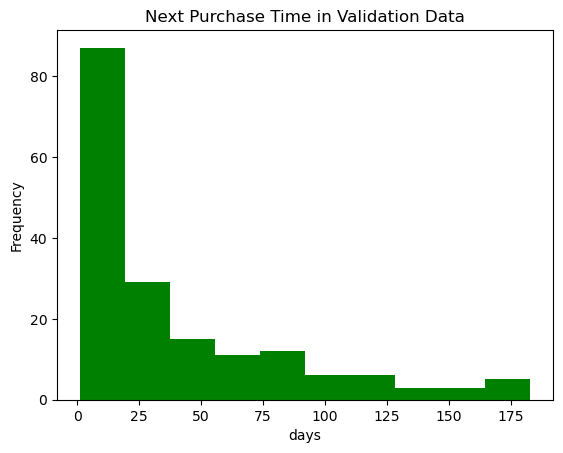

In [14]:
y_test.plot(kind="hist", color="green").set(title="Next Purchase Time in Validation Data", xlabel="days")

# Normalizing the data

In [15]:
cols_to_scale = ["mean_itte", "5th_percentile", "25th_percentile"
                 , "75th_percentile", "95th_percentile", "last_interval", "total_dur"]

# cols_to_scale = x_train.columns

for col in cols_to_scale:
    
    scaler = MinMaxScaler().fit(x_train[[col]])
    # scaler = StandardScaler().fit(x_train[[col]])
    x_train[col] = scaler.transform(x_train[[col]])
    x_test[col] = scaler.transform(x_test[[col]])

# Polynomial features to capture interaction

In [16]:
trans = PolynomialFeatures(degree=2, interaction_only=True)
x_train = pd.DataFrame(trans.fit_transform(x_train))
x_test = pd.DataFrame(trans.transform(x_test))

x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,1.0,3.0,6.0,6.0,0.375069,0.377436,0.462279,0.374511,0.335616,0.488372,...,0.454545,0.606061,0.151515,52.575758,12.0,3.0,1041.0,4.0,1388.0,347.0
1,1.0,2.0,34.0,34.0,0.249419,0.764103,0.348315,0.216322,0.199466,0.212209,...,3.000000,0.000000,2.000000,158.000000,0.0,6.0,474.0,0.0,0.0,316.0
2,1.0,9.0,20.0,20.0,0.106941,0.393846,0.128411,0.069312,0.096398,0.501453,...,0.000000,2.303030,0.000000,202.666667,0.0,0.0,0.0,0.0,1408.0,0.0
3,1.0,4.0,3.0,3.0,0.123215,0.068718,0.056180,0.133594,0.140774,0.213663,...,0.181818,0.000000,0.060606,9.575758,0.0,3.0,474.0,0.0,0.0,158.0
4,1.0,49.0,1.0,1.0,0.007971,0.004103,0.006421,0.008944,0.007114,0.943314,...,0.727273,0.181818,0.545455,120.545455,4.0,12.0,2652.0,3.0,663.0,1989.0


In [17]:
pca = PCA(n_components=50)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [18]:
y_train = y_train.reset_index(drop = True)

# GAMMA - GLM Model

In [19]:
import statsmodels.api as sm

glm_gamma= sm.GLM(y_train, sm.add_constant(x_train)
                  , family=sm.families.Gamma(link = sm.genmod.families.links.Log()))

res = glm_gamma.fit()

In [20]:
pred = res.predict(sm.add_constant(x_test))

In [21]:
print("ESTIMATED {:0.2f} PERCENTAGE CORRECTLY".format(return_guess_score(pred, y_test) * 100))
print("rmlse in estimation\t: ", math.sqrt(mean_squared_log_error(y_test, pred)))
print("rmse in estimation\t: ", math.sqrt(mean_squared_error(y_test, pred)))

ESTIMATED 70.06 PERCENTAGE CORRECTLY
rmlse in estimation	:  1.1084414644700527
rmse in estimation	:  40.11493189615632


In [22]:
new_dat = pd.DataFrame()
new_dat["actual_return_date"] = y_test.values
new_dat["predicted_return_date"] = pred

In [23]:
new_dat

,actual_return_date,predicted_return_date
0,82.0,32.779945
1,60.0,75.921468
2,68.0,63.987588
3,15.0,28.441137
4,10.0,27.839056
...,...,...
172,12.0,30.374021
173,114.0,82.655860
174,9.0,25.934625
175,130.0,67.930587


# Predicted Distribution

<AxesSubplot:ylabel='Count'>

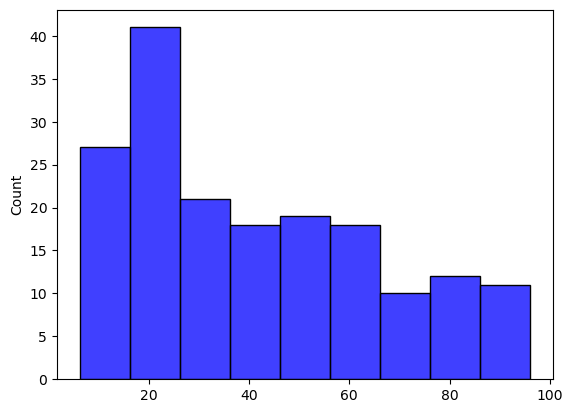

In [24]:
sns.histplot(pred, color="blue")

<AxesSubplot:title={'center':'actual vs predicted distribution'}, xlabel='next_purchase_day', ylabel='Density'>

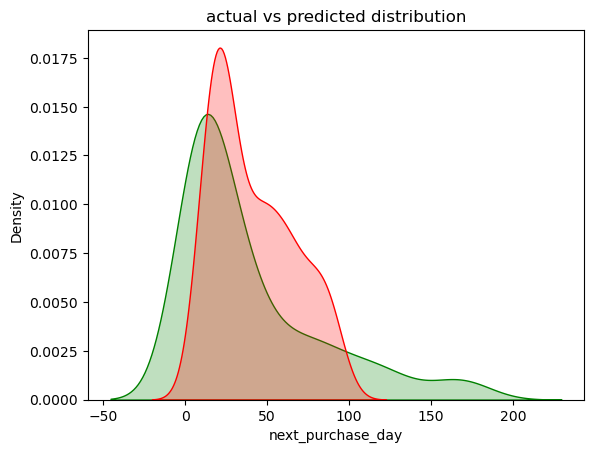

In [25]:
sns.kdeplot(y_test, color="green", fill=True).set(title = "actual vs predicted distribution")
sns.kdeplot(pred, color="red", fill=True)

# Captured Purchase Pattern

[Text(0.5, 1.0, 'predicted vs actual'), Text(0, 0.5, 'days')]

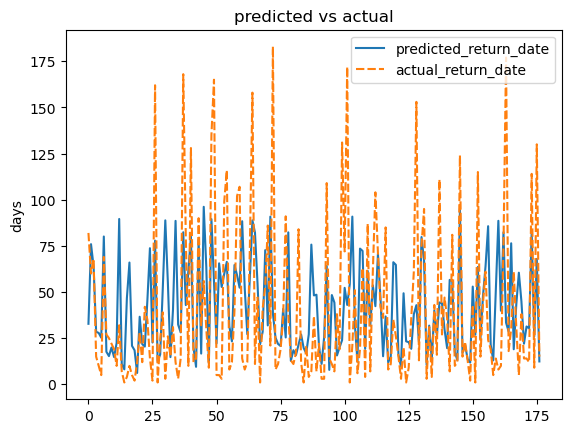

In [26]:
sns.lineplot(new_dat[["predicted_return_date", "actual_return_date"]]).set(title="predicted vs actual", ylabel = "days")

In [27]:
exact_dat = new_dat[new_dat["predicted_return_date"] >= new_dat["actual_return_date"].apply(lambda x: 0.85 * x)]
deviation_dat = new_dat[new_dat["predicted_return_date"] < new_dat["actual_return_date"].apply(lambda x: 0.85 * x)]

# Predictions that exactly match

[Text(0.5, 1.0, 'predicted vs actual'), Text(0, 0.5, 'days')]

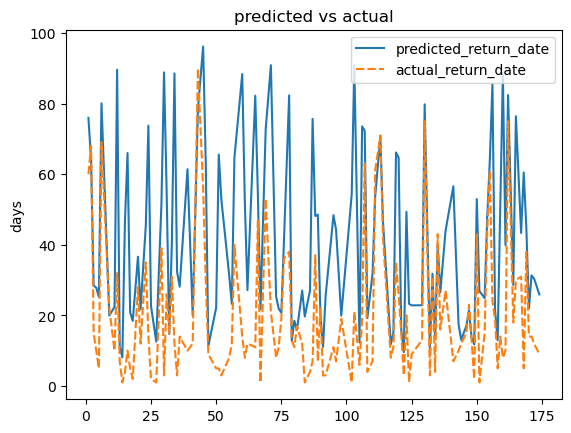

In [28]:
sns.lineplot(exact_dat[["predicted_return_date", "actual_return_date"]]).set(title="predicted vs actual", ylabel = "days")

# Predictions that deviates

[Text(0.5, 1.0, 'predicted vs actual'), Text(0, 0.5, 'days')]

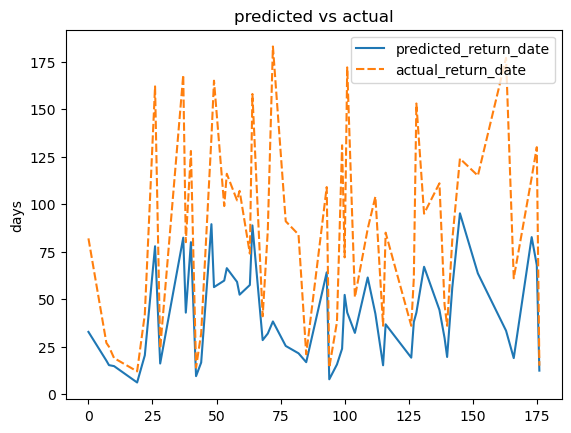

In [29]:
sns.lineplot(deviation_dat[["predicted_return_date", "actual_return_date"]]).set(title="predicted vs actual", ylabel = "days")

In [30]:
new_dat[new_dat["predicted_return_date"] >= new_dat["actual_return_date"].apply(lambda x: 0.95*x)]

,actual_return_date,predicted_return_date
1,60.0,75.921468
3,15.0,28.441137
4,10.0,27.839056
5,5.0,25.237958
6,69.0,80.069046
...,...,...
169,38.0,44.924772
170,14.0,22.011503
171,14.0,31.329058
172,12.0,30.374021


In [31]:
exact_dat.shape

(124, 2)

In [32]:
new_dat.shape

(177, 2)

In [33]:
new_dat

,actual_return_date,predicted_return_date
0,82.0,32.779945
1,60.0,75.921468
2,68.0,63.987588
3,15.0,28.441137
4,10.0,27.839056
...,...,...
172,12.0,30.374021
173,114.0,82.655860
174,9.0,25.934625
175,130.0,67.930587


In [34]:
x_train

array([[-2.72417115e+03, -2.66731014e+02, -7.45546836e+02, ...,
        -1.89438992e-03,  2.89056235e-03,  1.64382263e-02],
       [-3.61952427e+03,  4.29078248e+03,  1.04190202e+03, ...,
         2.25354562e-02, -7.84075743e-03,  8.69306440e-03],
       [-8.22107700e+02,  6.70583036e+03,  3.11614414e+02, ...,
         1.10752150e-03,  4.62026425e-02, -9.79850684e-02],
       ...,
       [-3.55090325e+03, -1.22285276e+03,  3.26148985e+02, ...,
        -2.53786291e-03, -2.57484265e-03, -3.59806208e-03],
       [-3.05714998e+03, -1.91277058e+03,  9.64542503e+01, ...,
         2.29500436e-02, -1.26474954e-02, -2.63636301e-02],
       [-2.58053476e+03, -2.38533926e+03,  6.63857254e+02, ...,
        -2.25706998e-02, -4.67997122e-03, -5.91539802e-03]])

In [35]:
math.sqrt(mean_squared_error(exact_dat["actual_return_date"], exact_dat["predicted_return_date"]))

30.40090884021085

In [36]:
math.sqrt(mean_squared_error(deviation_dat["actual_return_date"], deviation_dat["predicted_return_date"]))

56.67302470899992

# Regular regression

In [37]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x_train, y_train)
pred = reg.predict(x_test)

In [38]:
np.sqrt(mean_squared_error(y_test, pred)) 

40.59615728377504

In [39]:
return_guess_score(pred, y_test)

0.6949152542372882

In [40]:
new_dat = pd.DataFrame()
# new_dat["purchase_count"] = x_test["purchase_count"]
new_dat["actual_return_date"] = y_test.values
new_dat["predicted_return_date"] = pred

# Negative time prerdictions can be opbserved

<AxesSubplot:>

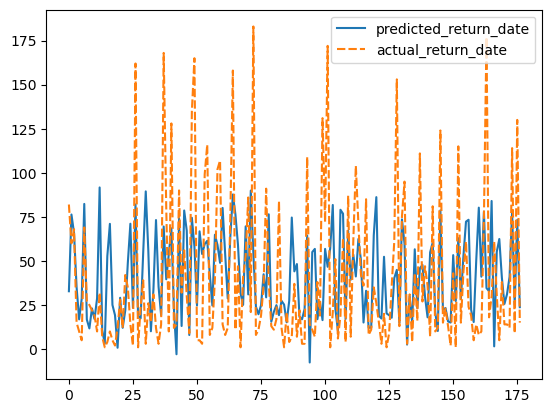

In [41]:
sns.lineplot(new_dat[["predicted_return_date", "actual_return_date"]])

# Assumes predicted data to be normally distributed

<AxesSubplot:xlabel='next_purchase_day', ylabel='Density'>

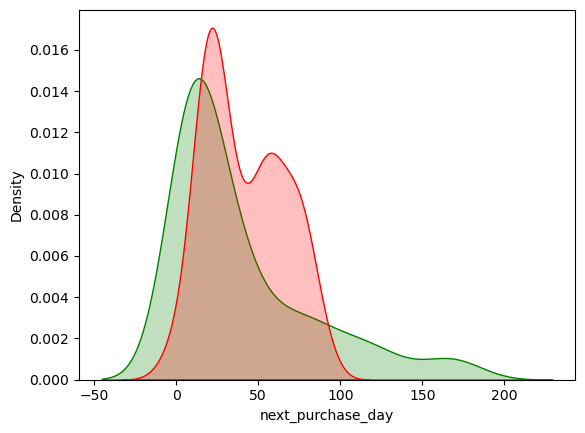

In [42]:
sns.kdeplot(y_test, color="green", fill=True)
sns.kdeplot(pred, color="red", fill=True)